In [10]:
import pandas as pd
import json
from transformers import GPT2Tokenizer, GPT2LMHeadModel, CLIPProcessor, CLIPModel
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AdamW
import torch
import torch.nn.functional as F
from torch import nn
import os
import matplotlib.pyplot as plt 

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Freeze all layers except the last few
num_layers_to_freeze = 10
for param in gpt2_model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for param in gpt2_model.transformer.h[num_layers_to_freeze:].parameters():
    param.requires_grad = True

# Additionally, ensure that the language modeling head is trainable
for param in gpt2_model.lm_head.parameters():
    param.requires_grad = True

# Verify the freezing
for name, param in gpt2_model.named_parameters():
    print(name, param.requires_grad)


tokenizer.pad_token = tokenizer.eos_token


transformer.wte.weight True
transformer.wpe.weight False
transformer.h.0.ln_1.weight False
transformer.h.0.ln_1.bias False
transformer.h.0.attn.c_attn.weight False
transformer.h.0.attn.c_attn.bias False
transformer.h.0.attn.c_proj.weight False
transformer.h.0.attn.c_proj.bias False
transformer.h.0.ln_2.weight False
transformer.h.0.ln_2.bias False
transformer.h.0.mlp.c_fc.weight False
transformer.h.0.mlp.c_fc.bias False
transformer.h.0.mlp.c_proj.weight False
transformer.h.0.mlp.c_proj.bias False
transformer.h.1.ln_1.weight False
transformer.h.1.ln_1.bias False
transformer.h.1.attn.c_attn.weight False
transformer.h.1.attn.c_attn.bias False
transformer.h.1.attn.c_proj.weight False
transformer.h.1.attn.c_proj.bias False
transformer.h.1.ln_2.weight False
transformer.h.1.ln_2.bias False
transformer.h.1.mlp.c_fc.weight False
transformer.h.1.mlp.c_fc.bias False
transformer.h.1.mlp.c_proj.weight False
transformer.h.1.mlp.c_proj.bias False
transformer.h.2.ln_1.weight False
transformer.h.2.ln_1.

In [11]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2_model.to(device)  # Move GPT-2 model to the device

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", do_rescale=False)

# Define image transform without normalization
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image)

def preprocess_prompt(prompt):
    return tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=56, pad_to_multiple_of=8).to(device)




In [12]:
class ImagePromptDataset(Dataset):
    def __init__(self, data, image_dir):
        self.data = data
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id = self.data[idx]['image_id']
        prompt = self.data[idx]['prompt']
        image_path = os.path.join(self.image_dir, image_id)

        image = preprocess_image(image_path).to(device)
        prompt = preprocess_prompt(prompt)

        return {
            "image": image,
            "input_ids": prompt["input_ids"].squeeze(0),
            "attention_mask": prompt["attention_mask"].squeeze(0)
        }


In [13]:
# Load the JSON file
json_path = '/kaggle/input/diffusion-images/part-000001/part-000001.json'
with open(json_path, 'r') as f:
    data = json.load(f)

# Convert the JSON data to a list of dictionaries for easier handling
dataset_data = [{'image_id': k, 'prompt': v['p']} for k, v in data.items()]

# Initialize the dataset and dataloader
image_dir = '/kaggle/input/diffusion-images/part-000001/'
dataset = ImagePromptDataset(dataset_data, image_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])  # <-- Split the dataset

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_tokens, num_layers=6, num_heads=8, ff_dim=2048, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, num_tokens)
        self.dropout = nn.Dropout(dropout)
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(self.dropout(x))
        return x

In [15]:
# Initialize the Transformer encoder
transformer_encoder = TransformerEncoder(input_dim=clip_model.config.projection_dim, num_tokens=gpt2_model.config.vocab_size).to(device)

# Initialize the optimizer
optimizer = AdamW(list(gpt2_model.parameters()) + list(transformer_encoder.parameters()), lr=5e-5)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(30):  # Adjust the number of epochs here
    gpt2_model.train()
    transformer_encoder.train()
    train_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to the correct device
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Preprocess images with CLIP
        inputs = clip_processor(images=images, return_tensors="pt").to(device)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device
        image_embeddings = clip_model.get_image_features(**inputs)

        # Map image embeddings to token logits using the transformer encoder
        token_logits = transformer_encoder(image_embeddings)

        # Generate text from the token logits using GPT-2
        outputs = gpt2_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluate on the test set
    gpt2_model.eval()
    transformer_encoder.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:  # <-- Evaluate on test_loader
            # Move data to the correct device
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Preprocess images with CLIP
            inputs = clip_processor(images=images, return_tensors="pt").to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device
            image_embeddings = clip_model.get_image_features(**inputs)

            # Map image embeddings to token logits using the transformer encoder
            token_logits = transformer_encoder(image_embeddings)

            # Generate text from the token logits using GPT-2
            outputs = gpt2_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )

            loss = outputs.loss
            test_loss += loss.item()

    # Calculate average test loss
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch: 0, Loss: 6.54660177230835
Epoch: 0, Loss: 6.636986255645752
Epoch: 0, Loss: 6.480526924133301
Epoch: 0, Loss: 6.187163829803467
Epoch: 0, Loss: 6.0114874839782715
Epoch: 0, Loss: 5.9605841636657715
Epoch: 0, Loss: 5.6548380851745605
Epoch: 0, Loss: 5.507258892059326
Epoch: 0, Loss: 5.329654693603516
Epoch: 0, Loss: 5.1600542068481445
Epoch: 0, Loss: 4.8862786293029785
Epoch: 0, Loss: 4.858029842376709
Epoch: 0, Loss: 4.737922191619873
Epoch: 0, Train Loss: 5.6890, Test Loss: 4.5410
Epoch: 1, Loss: 4.7325568199157715
Epoch: 1, Loss: 4.529388904571533
Epoch: 1, Loss: 4.485203742980957
Epoch: 1, Loss: 4.32328462600708
Epoch: 1, Loss: 4.383544921875
Epoch: 1, Loss: 3.651654005050659
Epoch: 1, Loss: 4.184392929077148
Epoch: 1, Loss: 3.971987009048462
Epoch: 1, Loss: 3.6869242191314697
Epoch: 1, Loss: 4.006558895111084
Epoch: 1, Loss: 3.7419915199279785
Epoch: 1, Loss: 3.8073809146881104
Epoch: 1, Loss: 3.5838677883148193
Epoch: 1, Train Loss: 4.0837, Test Loss: 3.5805
Epoch: 2, Loss:

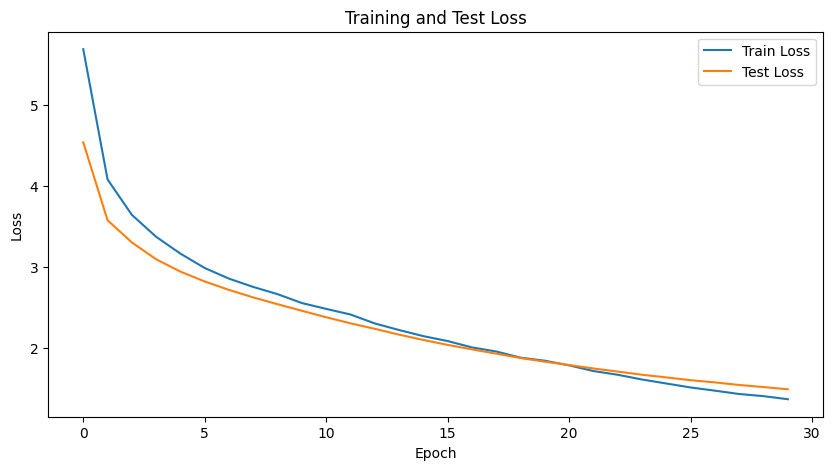

In [16]:
# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [ ]:
# # Function to preprocess image and generate prompt
# def generate_prompt_from_image(image_path):
#     # Preprocess the image using CLIP processor
#     image = Image.open(image_path).convert('RGB')
#     inputs = clip_processor(images=image, return_tensors="pt").to(device)
#     inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device

#     # Get image embeddings from CLIP
#     with torch.no_grad():
#         image_embeddings = clip_model.get_image_features(**inputs)

#     # Map image embeddings to token logits using the transformer encoder
#     token_logits = transformer_encoder(image_embeddings)

#     # Convert logits to token IDs
#     token_ids = token_logits.argmax(dim=-1)[:5].unsqueeze(0)  # Add batch dimension
#     #token_ids = torch.topk(token_logits.flatten(), 5).indices
#     print(token_ids)

#     # Generate text prompt using GPT-2
#     generated_ids = gpt2_model.generate(input_ids=token_ids, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
#     prompt = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

#     return prompt

In [17]:
#

def generate_prompt_from_image(image_path):
    # Preprocess the image using CLIP processor
    image = Image.open(image_path).convert('RGB')
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device

    # Get image embeddings from CLIP
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(**inputs)

    # Map image embeddings to token logits using the transformer encoder
    token_logits = transformer_encoder(image_embeddings)

    # Get the indices of the top 5 elements
    topk_values, topk_indices = torch.topk(token_logits, 1, dim=-1)

    # Select the top token ID
    token_ids = topk_indices.squeeze(0).unsqueeze(0)  # Add batch dimension
    print(token_ids)

    # Generate text prompt using GPT-2
    generated_ids = gpt2_model.generate(input_ids=token_ids, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
    prompt = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return prompt

In [19]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.3 MB/s eta 0:00:00a 0:00:01m


In [20]:
# Example usage
image_path = "/kaggle/input/seal-image/test_image2.png"
generated_prompt = generate_prompt_from_image(image_path)
print(generated_prompt)

from sentence_transformers import SentenceTransformer, util

reference_text = "photo of a seal balancing on a beach ball while balancing a beach ball on its nose in someone's backyard by an above ground swimming pool"

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode([reference_text, generated_prompt])
similarity = util.cos_sim(embeddings[0], embeddings[1])
print(f"Cosine Similarity: {similarity.item()}")

tensor([[17645]], device='cuda:0')
 outbreak of a plague in the city of  a village in the heart of the city, 


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity: -0.08407270908355713
